# DNN using Heart stroke data 

This work is aiming at the design and testing of a deep neural network architecture on Heart attack(1), Congestive heart disease(2), Coronary heart disease(3), and Stroke(4) using Tensorflow and Keras.

In [67]:
import numpy as np
import copy
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
from matplotlib import pyplot as plt
from numpy.random import seed
np.random.seed(2095)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [68]:
# read input file
file = '/Users/devil/Dropbox/CardiacPrediction_modified.xlsx'
ipData = pd.read_excel(file, sheet_name='CoroHeartDis')
print(ipData.columns) 

Index(['SEQN', 'Gender', 'Age', 'Annual-Family-Income',
       'Ratio-Family-Income-Poverty', 'X60-sec-pulse', 'Systolic', 'Diastolic',
       'Weight', 'Height', 'Body-Mass-Index', 'White-Blood-Cells',
       'Lymphocyte', 'Monocyte', 'Eosinophils', 'Basophils', 'Red-Blood-Cells',
       'Hemoglobin', 'Mean-Cell-Vol', 'Mean-Cell-Hgb-Conc.',
       'Mean-cell-Hemoglobin', 'Platelet-count', 'Mean-Platelet-Vol',
       'Segmented-Neutrophils', 'Hematocrit', 'Red-Cell-Distribution-Width',
       'Albumin', 'ALP', 'AST', 'ALT', 'Cholesterol', 'Creatinine', 'Glucose',
       'GGT', 'Iron', 'LDH', 'Phosphorus', 'Bilirubin', 'Protein', 'Uric.Acid',
       'Triglycerides', 'Total-Cholesterol', 'HDL', 'Glycohemoglobin',
       'Vigorous-work', 'Moderate-work', 'Health-Insurance', 'Diabetes',
       'Blood-Rel-Diabetes', 'Blood-Rel-Stroke', 'CoronaryHeartDisease'],
      dtype='object')


In [69]:
# data drop
opLabel = np.array(ipData['CoronaryHeartDisease'])
ipData.drop(['SEQN','CoronaryHeartDisease','Annual-Family-Income','Height','Ratio-Family-Income-Poverty',
             'X60-sec-pulse','Health-Insurance','Lymphocyte','Monocyte','Eosinophils','Total-Cholesterol',
             'Mean-Cell-Vol','Mean-Cell-Hgb-Conc.','Hematocrit','Segmented-Neutrophils'], axis = 1, inplace=True)

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.4)
def heatMap(df):
    #Create Correlation df
    corr = df.corr()
    #Plot figsize
    fig, ax = plt.subplots(figsize=(25, 25))
    #Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    #Generate Heat Map, allow annotations and place floats in map
    sns.heatmap(corr, cmap=colormap, annot = True, fmt=".2f")
    #Apply xticks
    plt.xticks(range(len(corr.columns)), corr.columns);
    #Apply yticks
    plt.yticks(range(len(corr.columns)), corr.columns)
    #show plot
    plt.show()

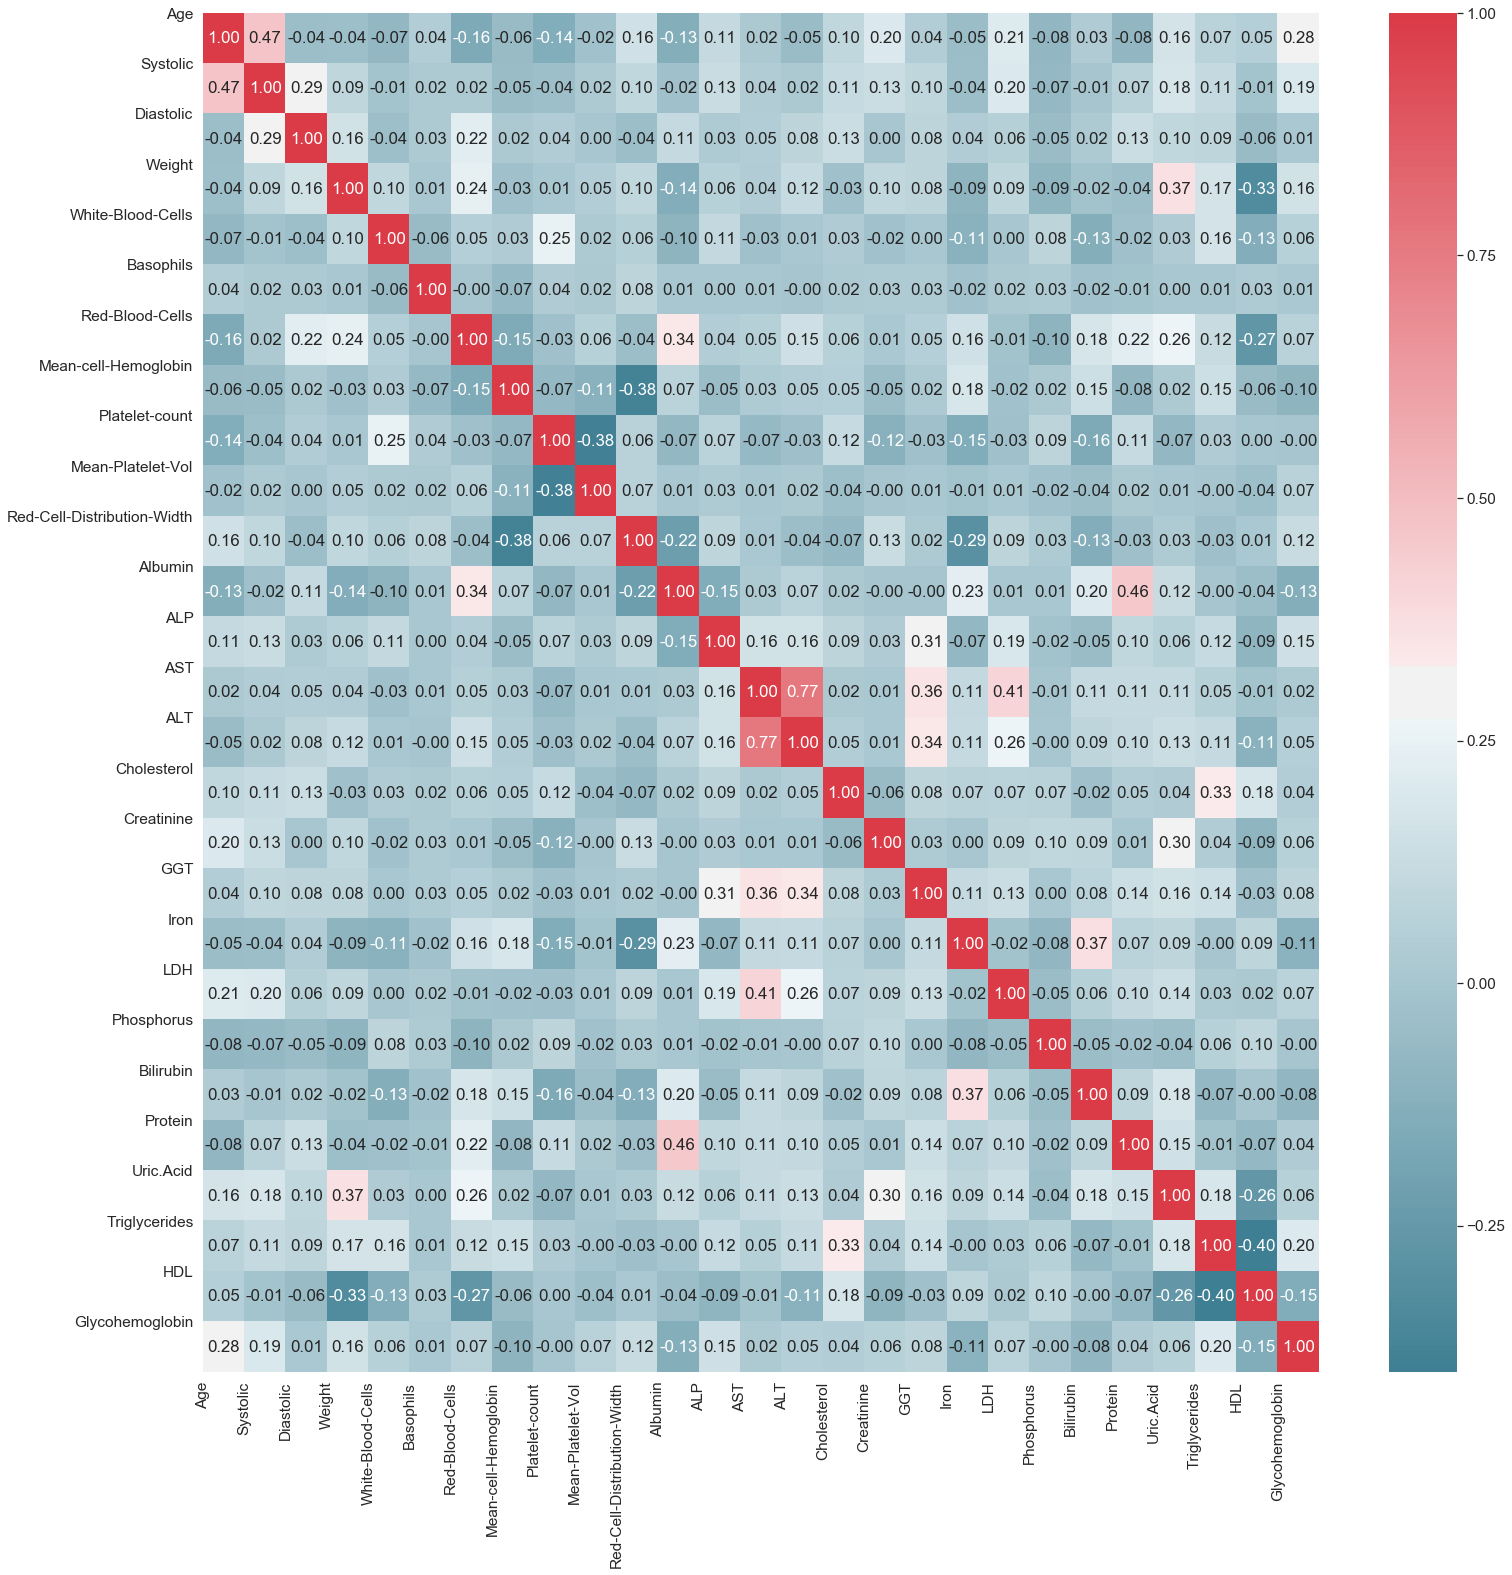

In [71]:
new_ipData = ipData.drop(['Gender','Body-Mass-Index','Hemoglobin','Glucose','Vigorous-work', 'Moderate-work', 'Diabetes',
       'Blood-Rel-Diabetes', 'Blood-Rel-Stroke'],axis = 1)
heatMap(new_ipData)

In [72]:
# dummy variable for categorical variables
ipData = pd.get_dummies(ipData,columns=["Gender","Diabetes","Blood-Rel-Diabetes","Blood-Rel-Stroke","Vigorous-work","Moderate-work"]) 

varb = np.array(ipData.columns)
ipData = np.array(ipData)

In [73]:
print(ipData.shape)
print(varb)
print(len(opLabel[opLabel==0]))
print(len(opLabel[opLabel==1]))

(37079, 45)
['Age' 'Systolic' 'Diastolic' 'Weight' 'Body-Mass-Index'
 'White-Blood-Cells' 'Basophils' 'Red-Blood-Cells' 'Hemoglobin'
 'Mean-cell-Hemoglobin' 'Platelet-count' 'Mean-Platelet-Vol'
 'Red-Cell-Distribution-Width' 'Albumin' 'ALP' 'AST' 'ALT' 'Cholesterol'
 'Creatinine' 'Glucose' 'GGT' 'Iron' 'LDH' 'Phosphorus' 'Bilirubin'
 'Protein' 'Uric.Acid' 'Triglycerides' 'HDL' 'Glycohemoglobin' 'Gender_1'
 'Gender_2' 'Diabetes_1' 'Diabetes_2' 'Diabetes_3' 'Blood-Rel-Diabetes_1'
 'Blood-Rel-Diabetes_2' 'Blood-Rel-Stroke_1' 'Blood-Rel-Stroke_2'
 'Vigorous-work_1' 'Vigorous-work_2' 'Vigorous-work_3' 'Moderate-work_1'
 'Moderate-work_2' 'Moderate-work_3']
35571
1508


In [74]:
#Data condensation using LASSO penalty
from sklearn.linear_model import Lasso, LogisticRegression


featureVote = np.zeros(ipData.shape[1])
print(featureVote.shape)

iteR = 100

for num in range(iteR):
    label0_indx = np.where(opLabel==0)[0]   #no cardiac arrest
    label1_indx = np.where(opLabel==1)[0]   #cardiac arrest 
    numTrainData0 = 1500
    numTrainData1 = 1300
    np.random.shuffle(label0_indx)
    np.random.shuffle(label1_indx)
    
    label0_indx_train = label0_indx[0:numTrainData0-1]
    label1_indx_train = label1_indx[0:numTrainData1-1]
    label0_indx_test  = label0_indx[numTrainData0-1:]
    label1_indx_test  = label1_indx[numTrainData1-1:]
    
    testIndx  = np.append(label0_indx_test,label1_indx_test)
    trainIndx = np.append(label0_indx_train,label1_indx_train)    
    trainData  =  ipData[trainIndx]
    trainLabel =  opLabel[trainIndx]
    testData   =  ipData[testIndx]
    testLabel  =  opLabel[testIndx]    
    
    ##%% data standardization
    scaler = preprocessing.StandardScaler().fit(trainData)
    trainData_scaled = scaler.transform(trainData)
    testData_scaled  = scaler.transform(testData)
    
    ##%% Elastic net and Lasso from scikit
    #regr = ElasticNet(random_state=0, alpha=1, l1_ratio=0.03, tol=0.000001, max_iter=100000)
    regr = Lasso(random_state=0, alpha=0.006, tol=0.000001, max_iter=100000)
    #regr = LogisticRegression(penalty='l1',random_state=0,C=100,tol=0.000001,max_iter=100,class_weight='balanced')
    regr.fit(trainData_scaled,trainLabel)
    cof = np.abs(regr.coef_)    
    colIndx = np.where(cof != 0)[0]
    for col in colIndx:
        featureVote[col]+=1

(45,)


In [75]:
print(featureVote)

[100.  34.  88.  36.  11.  91.  50.  73.   6.  18. 100.  45. 100.  46.
  30.  22.   9. 100.  89.  15.  36.  30. 100.  24.  41.  26. 100.  99.
  98.  98. 100.  40.  88.  75.   6.  82.  39. 100.  63.  13.   8.  88.
   1.  97.  61.]


In [76]:
# feature nomination via Lasso (from feature 1 to 35)
# We keep the dummy variables

featureIndx = np.where(featureVote[0:30]>=iteR//6)[0]
featureIndx = np.append(featureIndx, np.arange(30,ipData.shape[1]))
print(varb[featureIndx])

['Age' 'Systolic' 'Diastolic' 'Weight' 'White-Blood-Cells' 'Basophils'
 'Red-Blood-Cells' 'Mean-cell-Hemoglobin' 'Platelet-count'
 'Mean-Platelet-Vol' 'Red-Cell-Distribution-Width' 'Albumin' 'ALP' 'AST'
 'Cholesterol' 'Creatinine' 'GGT' 'Iron' 'LDH' 'Phosphorus' 'Bilirubin'
 'Protein' 'Uric.Acid' 'Triglycerides' 'HDL' 'Glycohemoglobin' 'Gender_1'
 'Gender_2' 'Diabetes_1' 'Diabetes_2' 'Diabetes_3' 'Blood-Rel-Diabetes_1'
 'Blood-Rel-Diabetes_2' 'Blood-Rel-Stroke_1' 'Blood-Rel-Stroke_2'
 'Vigorous-work_1' 'Vigorous-work_2' 'Vigorous-work_3' 'Moderate-work_1'
 'Moderate-work_2' 'Moderate-work_3']


In [77]:
featureIndx.shape

(41,)

# Dataset reduction (Re-run every time you change the number of training data)

In [78]:
reduced_data = ipData[:,featureIndx]

label0_indx = np.where(opLabel==0)[0]   #no cardiac arrest
label1_indx = np.where(opLabel==1)[0]   #cardiac arrest 
numTrainData0 = 1500
numTrainData1 = 1300
np.random.shuffle(label0_indx)
np.random.shuffle(label1_indx)

label0_indx_train = label0_indx[0:numTrainData0]
label1_indx_train = label1_indx[0:numTrainData1]
label0_indx_test  = label0_indx[numTrainData0:]
label1_indx_test  = label1_indx[numTrainData1:]

testIndx  = np.append(label0_indx_test,label1_indx_test)
trainIndx = np.append(label0_indx_train,label1_indx_train)    
x_train  =  reduced_data[trainIndx]
xtrain = x_train # to be used for MLP and Random Forest
y_train  =  opLabel[trainIndx]
ytrain = y_train # to be used for MLP and Random Forest
x_test   =  reduced_data[testIndx]
xtest = x_test # to be used for MLP and Random Forest
y_test   =  opLabel[testIndx]    
ytest = y_test 
print(xtest.shape)
print(xtrain.shape)
print(ytrain.shape)
print(ytest.shape)

(34279, 41)
(2800, 41)
(2800,)
(34279,)


In [79]:
scaler = preprocessing.StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test  = scaler.transform(x_test)

In [80]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [81]:
#%% one-hot-encoding
y_train = keras.utils.to_categorical(y_train,2)
y_test  = keras.utils.to_categorical(y_test,2)

In [82]:
y_test.shape
x_test.shape

(34279, 41, 1)

# Running the part above is MANDATORY for training any Network below

## MLP only

In [16]:
# MLP -2
inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(512, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

FC1    = keras.layers.Dense(128, bias_initializer=keras.initializers.VarianceScaling())(DP0)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
DP1    = keras.layers.Dropout(0.2)(AC1)


FC2 =   keras.layers.Dense(2, bias_initializer=keras.initializers.VarianceScaling())(DP1)
outputs = keras.layers.Activation('softmax')(FC2)

myMLP = keras.Model(inputs=inputs,outputs=outputs)
myMLP.compile(optimizer=keras.optimizers.Adam(lr=0.01),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
myMLP.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 1)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               26112     
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
__________

In [17]:
class_weight = {0: 1, 1: 10}

myMLP.fit(x_train,y_train,epochs=50,batch_size=500,verbose=1, class_weight=class_weight)

Epoch 1/50
5300/5300 [==============================] - 1s 241us/step - loss: 2.0520 - acc: 0.5638
Epoch 2/50
5300/5300 [==============================] - 0s 28us/step - loss: 1.3106 - acc: 0.7134
Epoch 3/50
5300/5300 [==============================] - 0s 27us/step - loss: 1.1359 - acc: 0.6625
Epoch 4/50
5300/5300 [==============================] - 0s 26us/step - loss: 1.0491 - acc: 0.6904
Epoch 5/50
5300/5300 [==============================] - 0s 28us/step - loss: 1.0230 - acc: 0.7013
Epoch 6/50
5300/5300 [==============================] - 0s 28us/step - loss: 0.9903 - acc: 0.7043
Epoch 7/50
5300/5300 [==============================] - 0s 27us/step - loss: 0.9640 - acc: 0.7177
Epoch 8/50
5300/5300 [==============================] - 0s 28us/step - loss: 0.9448 - acc: 0.7174
Epoch 9/50
5300/5300 [==============================] - 0s 28us/step - loss: 0.9177 - acc: 0.7160
Epoch 10/50
5300/5300 [==============================] - 0s 29us/step - loss: 0.8727 - acc: 0.7328
Epoch 11/50
5300/5

In [18]:
test_loss,test_acc = myMLP.evaluate(x_test,y_test)
print(test_acc)

31779/31779 [==============================] - 1s 32us/step
0.777022562069291


In [74]:
from sklearn import metrics
predlabel = myMLP.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

[[25518  5553]
 [    1     7]]


In [20]:
# MLP -3 :: Input => Hidden(64) => Hidden(128) => Hidden(256)
inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(64, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

FC1    = keras.layers.Dense(128, bias_initializer=keras.initializers.VarianceScaling())(DP0)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
DP1    = keras.layers.Dropout(0.2)(AC1)

FC2    = keras.layers.Dense(256, bias_initializer=keras.initializers.VarianceScaling())(DP1)
BN2    = keras.layers.BatchNormalization(axis=-1)(FC2)
AC2    = keras.layers.Activation('relu')(BN2)
#DP2    = keras.layers.Dropout(0.2)(AC2)


FC3 =   keras.layers.Dense(2, bias_initializer=keras.initializers.VarianceScaling())(AC2)
outputs = keras.layers.Activation('softmax')(FC3)

myMLP3 = keras.Model(inputs=inputs,outputs=outputs)
myMLP3.compile(optimizer=keras.optimizers.Adam(lr=0.01),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
myMLP3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50, 1)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                3264      
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
activation_4 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
__________

In [21]:
class_weight = {0: 1, 1: 1}

myMLP3.fit(x_train,y_train,epochs=100,batch_size=3000,verbose=1, class_weight=class_weight)

Epoch 1/100
5300/5300 [==============================] - 1s 163us/step - loss: 0.6843 - acc: 0.7236
Epoch 2/100
5300/5300 [==============================] - 0s 17us/step - loss: 0.5704 - acc: 0.7806
Epoch 3/100
5300/5300 [==============================] - 0s 21us/step - loss: 0.5174 - acc: 0.7708
Epoch 4/100
5300/5300 [==============================] - 0s 20us/step - loss: 0.4331 - acc: 0.7981
Epoch 5/100
5300/5300 [==============================] - 0s 21us/step - loss: 0.4147 - acc: 0.7996
Epoch 6/100
5300/5300 [==============================] - 0s 19us/step - loss: 0.3979 - acc: 0.8051
Epoch 7/100
5300/5300 [==============================] - 0s 18us/step - loss: 0.3804 - acc: 0.8185
Epoch 8/100
5300/5300 [==============================] - 0s 18us/step - loss: 0.3808 - acc: 0.8236
Epoch 9/100
5300/5300 [==============================] - 0s 21us/step - loss: 0.3709 - acc: 0.8243
Epoch 10/100
5300/5300 [==============================] - 0s 18us/step - loss: 0.3727 - acc: 0.8191
Epoch 11

5300/5300 [==============================] - 0s 21us/step - loss: 0.1954 - acc: 0.9172
Epoch 84/100
5300/5300 [==============================] - 0s 25us/step - loss: 0.1964 - acc: 0.9174
Epoch 85/100
5300/5300 [==============================] - 0s 22us/step - loss: 0.1989 - acc: 0.9177
Epoch 86/100
5300/5300 [==============================] - 0s 20us/step - loss: 0.1917 - acc: 0.9200
Epoch 87/100
5300/5300 [==============================] - 0s 18us/step - loss: 0.1941 - acc: 0.9179
Epoch 88/100
5300/5300 [==============================] - 0s 19us/step - loss: 0.1893 - acc: 0.9162
Epoch 89/100
5300/5300 [==============================] - 0s 21us/step - loss: 0.1793 - acc: 0.9243
Epoch 90/100
5300/5300 [==============================] - 0s 24us/step - loss: 0.1915 - acc: 0.9223
Epoch 91/100
5300/5300 [==============================] - 0s 22us/step - loss: 0.1926 - acc: 0.9179
Epoch 92/100
5300/5300 [==============================] - 0s 19us/step - loss: 0.1828 - acc: 0.9177
Epoch 93/100


In [22]:
test_loss,test_acc = myMLP3.evaluate(x_test,y_test)
print(test_acc)

31779/31779 [==============================] - 1s 35us/step
0.931841782309072


In [23]:
from sklearn import metrics
predlabel = myMLP3.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

[[29535  2036]
 [  130    78]]


# Introducing convolutional layers

## MLP+Conv :: Input => Hidden(128)  => Conv(4) => Output (2)

In [24]:

inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(128, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

RS1    = keras.layers.Reshape((128,1))(DP0)
FC1    = keras.layers.Conv1D(4,3,strides=1)(RS1)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
Pool1 = keras.layers.MaxPool1D(pool_size=2)(AC1)
FL1   = keras.layers.Flatten()(Pool1)

FC3 =   keras.layers.Dense(2, bias_initializer=keras.initializers.VarianceScaling())(FL1)
outputs = keras.layers.Activation('softmax')(FC3)

myCNN1D1 = keras.Model(inputs=inputs,outputs=outputs)
myCNN1D1.compile(optimizer=keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

myCNN1D1.summary()

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 50, 1)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               6528      
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
activation_8 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
___________________________________________________________

In [25]:
class_weight = {0: 1, 1: 5}

myCNN1D1.fit(x_train,y_train,epochs=10,verbose=1, class_weight=class_weight)

Epoch 1/10
5300/5300 [==============================] - 2s 286us/step - loss: 1.1672 - acc: 0.6343
Epoch 2/10
5300/5300 [==============================] - 1s 138us/step - loss: 0.9489 - acc: 0.7117
Epoch 3/10
5300/5300 [==============================] - 1s 140us/step - loss: 0.9002 - acc: 0.7283
Epoch 4/10
5300/5300 [==============================] - 1s 141us/step - loss: 0.8568 - acc: 0.7394
Epoch 5/10
5300/5300 [==============================] - 1s 143us/step - loss: 0.8266 - acc: 0.7466
Epoch 6/10
5300/5300 [==============================] - 1s 185us/step - loss: 0.8190 - acc: 0.7475
Epoch 7/10
5300/5300 [==============================] - 1s 184us/step - loss: 0.7893 - acc: 0.7551
Epoch 8/10
5300/5300 [==============================] - 1s 160us/step - loss: 0.7889 - acc: 0.7585
Epoch 9/10
5300/5300 [==============================] - 1s 147us/step - loss: 0.7681 - acc: 0.7642
Epoch 10/10
5300/5300 [==============================] - 1s 148us/step - loss: 0.7725 - acc: 0.7636


In [26]:
test_loss,test_acc = myCNN1D1.evaluate(x_test,y_test)
print(test_acc)

31779/31779 [==============================] - 2s 54us/step
0.6637087384750936


In [27]:
from sklearn import metrics
predlabel = myCNN1D1.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

[[20910 10661]
 [   26   182]]


##  MLP+CONV: Input => Hidden(128)  => Conv(4) => Conv(8) => Output (2)

In [28]:
inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(128, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

RS1    = keras.layers.Reshape((128,1))(DP0)
FC1    = keras.layers.Conv1D(4,3,strides=1)(RS1)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
Pool1 = keras.layers.AveragePooling1D(pool_size=2)(AC1)

FC2    = keras.layers.Conv1D(8,5,strides=1)(Pool1)
BN2    = keras.layers.BatchNormalization(axis=-1)(FC2)
AC2    = keras.layers.Activation('relu')(BN2)
Pool2 = keras.layers.AveragePooling1D(pool_size=2)(AC2)

FL1   = keras.layers.Flatten()(Pool2)

FC3 =   keras.layers.Dense(2, bias_initializer=keras.initializers.VarianceScaling())(FL1)
outputs = keras.layers.Activation('softmax')(FC3)

myCNN1D2 = keras.Model(inputs=inputs,outputs=outputs)
myCNN1D2.compile(optimizer=keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

myCNN1D2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 50, 1)             0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               6528      
_________________________________________________________________
batch_normalization_8 (Batch (None, 128)               512       
_________________________________________________________________
activation_11 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 128, 1)            0         
__________

In [29]:
class_weight = {0: 1, 1: 10}

myCNN1D2.fit(x_train,y_train,epochs=50,verbose=1, class_weight=class_weight)

Epoch 1/50
5300/5300 [==============================] - 2s 354us/step - loss: 1.4510 - acc: 0.4683
Epoch 2/50
5300/5300 [==============================] - 1s 185us/step - loss: 1.2580 - acc: 0.6094
Epoch 3/50
5300/5300 [==============================] - 1s 187us/step - loss: 1.1706 - acc: 0.6406
Epoch 4/50
5300/5300 [==============================] - 1s 211us/step - loss: 1.1302 - acc: 0.6664
Epoch 5/50
5300/5300 [==============================] - 1s 202us/step - loss: 1.1023 - acc: 0.6632
Epoch 6/50
5300/5300 [==============================] - 1s 190us/step - loss: 1.0892 - acc: 0.6704
Epoch 7/50
5300/5300 [==============================] - 1s 211us/step - loss: 1.0451 - acc: 0.6849
Epoch 8/50
5300/5300 [==============================] - 1s 233us/step - loss: 1.0242 - acc: 0.6913
Epoch 9/50
5300/5300 [==============================] - 1s 190us/step - loss: 1.0205 - acc: 0.6947
Epoch 10/50
5300/5300 [==============================] - 1s 217us/step - loss: 1.0166 - acc: 0.6940
Epoch 11/

In [31]:
test_loss,test_acc = myCNN1D2.evaluate(x_test,y_test)
print(test_acc)

31779/31779 [==============================] - 2s 60us/step
0.7546807640265584


In [32]:
from sklearn import metrics
predlabel = myCNN1D2.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

[[23834  7737]
 [   59   149]]


## MLP+Conv :: Input => Hidden(64) => Conv(2) => Hidden(512)  

In [33]:

inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(32, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

RS1    = keras.layers.Reshape((32,1))(DP0)
FC1    = keras.layers.Conv1D(2,3,strides=1)(RS1)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
Pool1 = keras.layers.MaxPool1D(pool_size=2)(AC1)
FL1   = keras.layers.Flatten()(Pool1)

FC2    = keras.layers.Dense(512, bias_initializer=keras.initializers.VarianceScaling())(FL1)
BN2    = keras.layers.BatchNormalization(axis=-1)(FC2)
AC2    = keras.layers.Activation('relu')(BN2)
#DP2    = keras.layers.Dropout(0.2)(AC2)


FC3 =   keras.layers.Dense(2, bias_initializer=keras.initializers.VarianceScaling())(AC2)
outputs = keras.layers.Activation('softmax')(FC3)

myCNN1D3 = keras.Model(inputs=inputs,outputs=outputs)
myCNN1D3.compile(optimizer=keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
myCNN1D3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 50, 1)             0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 50)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                1632      
_________________________________________________________________
batch_normalization_11 (Batc (None, 32)                128       
_________________________________________________________________
activation_15 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
reshape_8 (Reshape)          (None, 32, 1)             0         
__________

In [34]:
class_weight = {0: 1, 1: 4}

myCNN1D3.fit(x_train,y_train,epochs=50,verbose=1, class_weight=class_weight)

Epoch 1/50
5300/5300 [==============================] - 2s 286us/step - loss: 1.1021 - acc: 0.6398
Epoch 2/50
5300/5300 [==============================] - 1s 123us/step - loss: 0.9354 - acc: 0.6977
Epoch 3/50
5300/5300 [==============================] - 1s 120us/step - loss: 0.8824 - acc: 0.7174
Epoch 4/50
5300/5300 [==============================] - 1s 124us/step - loss: 0.8619 - acc: 0.7209
Epoch 5/50
5300/5300 [==============================] - 1s 127us/step - loss: 0.8278 - acc: 0.7330
Epoch 6/50
5300/5300 [==============================] - 1s 137us/step - loss: 0.8167 - acc: 0.7385
Epoch 7/50
5300/5300 [==============================] - 1s 139us/step - loss: 0.8024 - acc: 0.7413
Epoch 8/50
5300/5300 [==============================] - 1s 137us/step - loss: 0.7906 - acc: 0.7432
Epoch 9/50
5300/5300 [==============================] - 1s 130us/step - loss: 0.7867 - acc: 0.7434
Epoch 10/50
5300/5300 [==============================] - 1s 156us/step - loss: 0.7825 - acc: 0.7351
Epoch 11/

In [35]:
test_loss,test_acc = myCNN1D3.evaluate(x_test,y_test)
print(test_acc)

31779/31779 [==============================] - 1s 44us/step
0.7730891469209227


In [36]:
from sklearn import metrics
predlabel = myCNN1D3.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

[[24409  7162]
 [   49   159]]


## MLP+ CONV: Input => Dense(64) => Conv(2) => Conv(4) = Dense(512) => Dense (2) [Best]

In [199]:
inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(64, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

RS1    = keras.layers.Reshape((64,1))(DP0)
FC1    = keras.layers.Conv1D(2,3,strides=1)(RS1)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
Pool1  = keras.layers.AveragePooling1D(pool_size=2)(AC1)

FC2    = keras.layers.Conv1D(4,5,strides=1)(Pool1)
BN2    = keras.layers.BatchNormalization(axis=-1)(FC2)
AC2    = keras.layers.Activation('relu')(BN2)
Pool2  = keras.layers.AveragePooling1D(pool_size=2)(AC2)

FL1    = keras.layers.Flatten()(Pool2)

FC3    = keras.layers.Dense(512, bias_initializer=keras.initializers.VarianceScaling())(FL1)
BN3    = keras.layers.BatchNormalization(axis=-1)(FC3)
AC3    = keras.layers.Activation('relu')(BN3)
DP3    = keras.layers.Dropout(0.2)(AC3)


FC4    = keras.layers.Dense(2)(DP3)
outputs = keras.layers.Activation('softmax')(FC4)

myCNN1D4 = keras.Model(inputs=inputs,outputs=outputs)
myCNN1D4.compile(optimizer=keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

myCNN1D4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 41, 1)             0         
_________________________________________________________________
reshape_8 (Reshape)          (None, 41)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                2688      
_________________________________________________________________
batch_normalization_15 (Batc (None, 64)                256       
_________________________________________________________________
activation_20 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 64, 1)             0         
__________

Epoch 1/100
2800/2800 [==============================] - 1s 443us/step - loss: 0.3351 - acc: 0.8475
Epoch 2/100
2800/2800 [==============================] - 1s 417us/step - loss: 0.3303 - acc: 0.8646
Epoch 3/100
2800/2800 [==============================] - 1s 430us/step - loss: 0.3294 - acc: 0.8593
Epoch 4/100
2800/2800 [==============================] - 1s 493us/step - loss: 0.3207 - acc: 0.8643
Epoch 5/100
2800/2800 [==============================] - 1s 450us/step - loss: 0.3365 - acc: 0.8546
Epoch 6/100
2800/2800 [==============================] - 1s 435us/step - loss: 0.3402 - acc: 0.8554
Epoch 7/100
2800/2800 [==============================] - 1s 486us/step - loss: 0.3312 - acc: 0.8536
Epoch 8/100
2800/2800 [==============================] - 2s 594us/step - loss: 0.3247 - acc: 0.8646
Epoch 9/100
2800/2800 [==============================] - 1s 446us/step - loss: 0.3375 - acc: 0.8454
Epoch 10/100
2800/2800 [==============================] - 1s 469us/step - loss: 0.3304 - acc: 0.8593

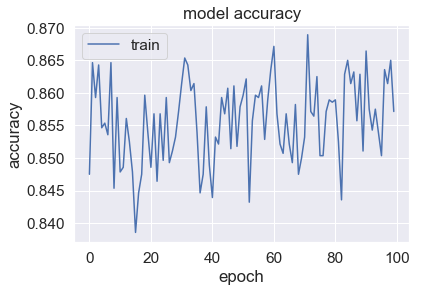

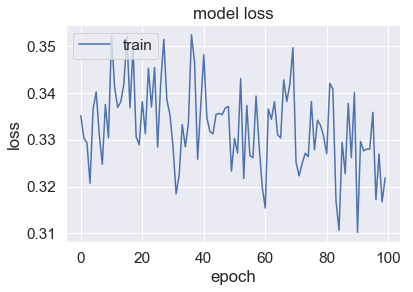

In [214]:
class_weight = {0: 1, 1: 1}

history = myCNN1D4.fit(x_train,y_train,epochs=100,batch_size = 10, verbose=1, class_weight=class_weight)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [215]:
test_loss,test_acc = myCNN1D4.evaluate(x_test,y_test)
print(test_acc)

34279/34279 [==============================] - 2s 66us/step
0.7538142886350013


Confusion Matrix:  25698 8373 66 142
Recall:  68.26923076923077
Precision:  1.6676453317674693
Specificity:  75.424848111297
Type I error:  31.73076923076923
Type II error:  24.575151888703004
AUC:  71.84703944026388


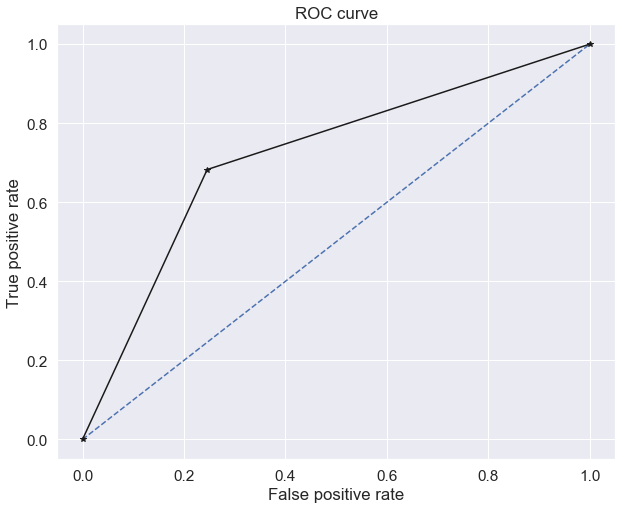

In [218]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
predlabel = myCNN1D4.predict(x_test)
f = np.argmax(predlabel,axis=1)
tn_test, fp_test, fn_test, tp_test = metrics.confusion_matrix(np.argmax(y_test,axis=1),f).flatten()

type_I_error_test = (1 - (tp_test/(tp_test+fn_test))) * 100
type_II_error_test = (1 - (tn_test/(tn_test+fp_test))) * 100

print("Confusion Matrix: ", tn_test, fp_test, fn_test, tp_test)
print("Recall: ", (tp_test/(tp_test+fn_test))*100)
print("Precision: ", (tp_test/(tp_test+fp_test))*100)
print("Specificity: ", (tn_test/(tn_test+fp_test))*100)
print("Type I error: ", type_I_error_test)
print("Type II error: ", type_II_error_test)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(np.argmax(y_test,axis=1),f)
from sklearn.metrics import auc
auc = auc(fpr_keras, tpr_keras)
print("AUC: ", auc*100)

# plot no skill
plt.figure(figsize=(10,8))
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_keras, tpr_keras, color = 'k', marker="*", label='Keras (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
#plt.legend(loc='best')
# show the plot
plt.show()  

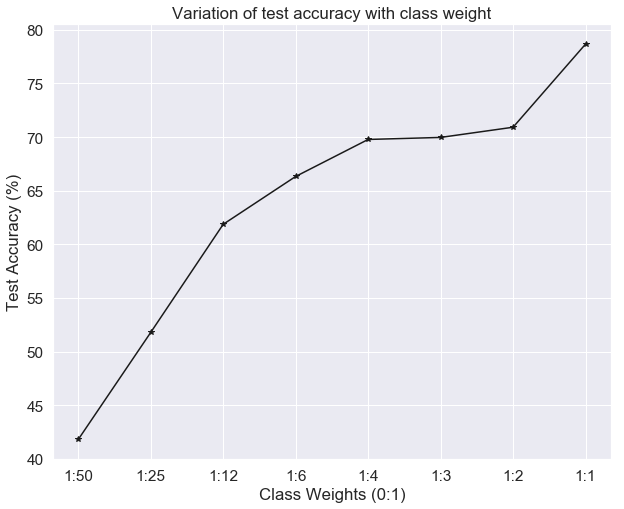

In [207]:
import matplotlib.pyplot as plt

x = ["1:50","1:25","1:12","1:6","1:4","1:3","1:2","1:1"]
y = [41.81, 51.79, 61.87, 66.33, 69.78, 69.97, 70.92, 78.67]
plt.figure(figsize=(10,8))
plt.plot(x,y, c = 'k', alpha = None, marker = "*")
plt.title('Variation of test accuracy with class weight')
plt.xlabel('Class Weights (0:1)')
plt.ylabel('Test Accuracy (%)')
plt.show()

# The following section shows the result for MLP only

In [182]:
# MLP -2
inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(512, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

FC1    = keras.layers.Dense(128, bias_initializer=keras.initializers.VarianceScaling())(DP0)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
DP1    = keras.layers.Dropout(0.2)(AC1)


FC2 =   keras.layers.Dense(2, bias_initializer=keras.initializers.VarianceScaling())(DP1)
outputs = keras.layers.Activation('softmax')(FC2)

myMLP = keras.Model(inputs=inputs,outputs=outputs)
myMLP.compile(optimizer=keras.optimizers.Adam(lr=0.01),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
myMLP.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 41, 1)             0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 41)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               21504     
_________________________________________________________________
batch_normalization_13 (Batc (None, 512)               2048      
_________________________________________________________________
activation_17 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               65664     
__________

In [197]:
class_weight = {0: 1, 1: 1}

myMLP.fit(x_train,y_train,epochs=50,batch_size = 10, verbose=1, class_weight=class_weight)

Epoch 1/50
2800/2800 [==============================] - 1s 295us/step - loss: 0.2571 - acc: 0.8921
Epoch 2/50
2800/2800 [==============================] - 1s 276us/step - loss: 0.2637 - acc: 0.8918
Epoch 3/50
2800/2800 [==============================] - 1s 253us/step - loss: 0.2572 - acc: 0.8939
Epoch 4/50
2800/2800 [==============================] - 1s 251us/step - loss: 0.2532 - acc: 0.8889
Epoch 5/50
2800/2800 [==============================] - 1s 275us/step - loss: 0.2907 - acc: 0.8768
Epoch 6/50
2800/2800 [==============================] - 1s 300us/step - loss: 0.2753 - acc: 0.8857
Epoch 7/50
2800/2800 [==============================] - 1s 273us/step - loss: 0.2753 - acc: 0.8914
Epoch 8/50
2800/2800 [==============================] - 1s 277us/step - loss: 0.2535 - acc: 0.8961
Epoch 9/50
2800/2800 [==============================] - 1s 321us/step - loss: 0.2559 - acc: 0.8964
Epoch 10/50
2800/2800 [==============================] - 1s 280us/step - loss: 0.2755 - acc: 0.8814
Epoch 11/

In [198]:
test_loss,test_acc = myMLP.evaluate(x_test,y_test)
print(test_acc)

34279/34279 [==============================] - 1s 36us/step
0.785641354767047


In [217]:
from sklearn import metrics
predlabel = myMLP.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

[[26790  7281]
 [   67   141]]


# Random Forest

In [98]:
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [99]:
scaler = preprocessing.StandardScaler().fit(xtrain)
xtrain = scaler.transform(xtrain)
xtest  = scaler.transform(xtest)

In [153]:
from sklearn.ensemble import RandomForestClassifier
class_weight = {0: 1, 1: 3}
rf = RandomForestClassifier(n_estimators=500, random_state=12, class_weight = class_weight)
model = rf.fit(xtrain, ytrain)
print(model)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 3},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=None, oob_score=False,
            random_state=12, verbose=0, warm_start=False)


In [154]:
from sklearn.metrics import accuracy_score
predicted = model.predict(xtest)
predicted_train = model.predict(xtrain)
acc_test = accuracy_score(ytest, predicted)
acc_train = accuracy_score(ytrain,predicted_train )
print("Train accuracy: ", acc_train)
print("Test accuracy: ", acc_test)

Train accuracy:  1.0
Test accuracy:  0.7899296945651857


In [155]:
threshold = 0.5

predicted_proba = model.predict_proba(xtest)
new_pred = (predicted_proba [:,1] >= threshold).astype('int')

accuracy = accuracy_score(ytest, new_pred)
print("Accuracy: ", accuracy)

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
con = confusion_matrix(ytest, new_pred)

#tn_train, fp_train, fn_train, tp_train = confusion_matrix(ytrain, mlp.predict(xtrain)).flatten()
tn_test, fp_test, fn_test, tp_test = confusion_matrix(ytest, new_pred).flatten()
type_I_error_test = (1 - (tp_test/(tp_test+fn_test))) * 100
type_II_error_test = (1 - (tn_test/(tn_test+fp_test))) * 100
print(tn_test, fp_test, fn_test, tp_test)
print("Recall: ", (tp_test/(tp_test+fn_test))*100)
#print("Precision: ", (tp_test/(tp_test+fp_test))*100)
print("Specificity: ", (tn_test/(tn_test+fp_test))*100)
print("Type I error: ", type_I_error_test)
print("Type II error: ", type_II_error_test)

Accuracy:  0.7887627993815456
26885 7186 55 153
Recall:  73.5576923076923
Specificity:  78.90874937630242
Type I error:  26.442307692307686
Type II error:  21.091250623697576


In [156]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# predict probabilities
probs = model.predict_proba(xtest)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(ytest, probs)
print("AUC value of the model: ", auc)

AUC value of the model:  0.8482801327770291


# Support Vector Machine

In [136]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
svc = SVC(C = 0.05, kernel = 'rbf', probability = True, class_weight = {0:1, 1:1}, verbose = True)
model_svc = svc.fit(xtrain, ytrain)

[LibSVM]

In [137]:
from sklearn.metrics import accuracy_score
y_pred = model_svc.predict(xtest)
y_pred_train = model_svc.predict(xtrain)
print("Train set score: %f" % accuracy_score(ytrain, y_pred_train))
print("Test set score: %f" % accuracy_score(ytest,y_pred))

Train set score: 0.777143
Test set score: 0.746550


In [138]:
#Confusion Matrix
con = confusion_matrix(ytest, y_pred)
tn_test, fp_test, fn_test, tp_test = confusion_matrix(ytest, y_pred).flatten()

#Type I and Type II error
type_I_error_test = (1 - (tp_test/(tp_test+fn_test))) * 100
type_II_error_test = (1 - (tn_test/(tn_test+fp_test))) * 100

#Printing
print(tn_test, fp_test, fn_test, tp_test)
print("Recall: ", (tp_test/(tp_test+fn_test))*100)
#print("Precision: ", (tp_test/(tp_test+fp_test))*100)
print("Accuracy: ", (tp_test + tn_test)*100/(tn_test + fp_test + fn_test + tp_test))
print("Specificity: ", (tn_test/(tn_test+fp_test))*100)
print("Type I error: ", type_I_error_test)
print("Type II error: ", type_II_error_test)

#Calculate AUC
probs = svc.predict_proba(xtest)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(ytest, probs)
print('AUC: %.3f' % auc)

25427 8644 44 164
Recall:  78.84615384615384
Accuracy:  74.65503661133639
Specificity:  74.62945026562178
Type I error:  21.153846153846157
Type II error:  25.370549734378212
AUC: 0.838


# Logistic Regression

In [225]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver = 'lbfgs',max_iter=100000, 
                           class_weight= {0:1, 1:1}, verbose=1, random_state = 2)
model = clf.fit(xtrain, ytrain)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [226]:
predict = model.predict(xtest)
predict_train = model.predict(xtrain)

print("Train set score: %f" % accuracy_score(ytrain, predict_train))
print("Test set score: %f" % accuracy_score(ytest, predict))

Train set score: 0.792857
Test set score: 0.788792


In [228]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

#Confusion Matrix
con = confusion_matrix(ytest, predict)
#tn_train, fp_train, fn_train, tp_train = confusion_matrix(ytrain, mlp.predict(xtrain)).flatten()
tn_test, fp_test, fn_test, tp_test = confusion_matrix(ytest, predict).flatten()

#Type I & Type II error
type_I_error_test = (1 - (tp_test/(tp_test+fn_test))) * 100
type_II_error_test = (1 - (tn_test/(tn_test+fp_test))) * 100

#Printing
print(tn_test, fp_test, fn_test, tp_test)
print("Recall: ", (tp_test/(tp_test+fn_test))*100)
#print("Precision: ", (tp_test/(tp_test+fp_test))*100)
print("Specificity: ", (tn_test/(tn_test+fp_test))*100)
print("Type I error: ", type_I_error_test)
print("Type II error: ", type_II_error_test)

# predict probabilities
probs = clf.predict_proba(xtest)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(ytest, probs)
print('AUC: %.3f' % auc)

26875 7196 44 164
Recall:  78.84615384615384
Specificity:  78.87939890229228
Type I error:  21.153846153846157
Type II error:  21.120601097707727
AUC: 0.854
